<a href="https://colab.research.google.com/github/GaoangLiu/AA_ipynb/blob/master/Disaster_Tweets_with_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use Logistic Regression to classify tweets on disaster are real or not. 

CNN way can be found [here](https://github.com/GaoangLiu/AA_ipynb/blob/master/NLP_with_Disaster_Tweets.ipynb)

Naive Bayes can be found [here](https://github.com/GaoangLiu/AA_ipynb/blob/master/NLP_with_Disaster_Tweets.ipynb)


In [2]:
# Load packages 
import math
import re
import os
import timeit
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import logging
import time
import smart_open
import importlib

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
logging.basicConfig(format='[%(asctime)s %(levelname)8s] %(message)s', level=logging.INFO, datefmt='%m-%d %H:%M:%S')

from keras import layers, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, Model, load_model
from keras.layers import Flatten, Dense, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api

import tensorflow_hub as hub 
import tensorflow as tf 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
[05-15 03:44:05     INFO] 'pattern' package not found; tag filters are not available for English


Download data

In [3]:
! rm *.csv *.zip
! wget -O tweets.zip ali.140714.xyz:8000/nlp-getting-started.zip 
! unzip tweets.zip 
! ls
! wget -O labels.csv ali.140714.xyz:8000/leaked_tweet_labels.csv
! wget -O B7.py ali.140714.xyz:8000/boost117.py
import B7 # boost117

--2020-05-15 03:44:11--  http://ali.140714.xyz:8000/nlp-getting-started.zip
Resolving ali.140714.xyz (ali.140714.xyz)... 47.240.16.188
Connecting to ali.140714.xyz (ali.140714.xyz)|47.240.16.188|:8000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘tweets.zip’

tweets.zip          100%[===================>] 593.11K  --.-KB/s    in 0.07s   

2020-05-15 03:44:11 (8.58 MB/s) - ‘tweets.zip’ saved [607343/607343]

Archive:  tweets.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
B7.py	     sample_data	    test.csv   tweets.zip
__pycache__  sample_submission.csv  train.csv
--2020-05-15 03:44:20--  http://ali.140714.xyz:8000/leaked_tweet_labels.csv
Resolving ali.140714.xyz (ali.140714.xyz)... 47.240.16.188
Connecting to ali.140714.xyz (ali.140714.xyz)|47.240.16.188|:8000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22746 (22K) [text/csv]

In [0]:
train = pd.read_csv('train.csv')
train[train.text.str.lower().str.contains("hijacking computers")]

# Straightfoward SVM model

In [0]:
class Classifier():
  def __init__(self):
    self.train = None
    self.test = None 
    self.model = None
    
  def load_data(self, train_file='train.csv', test_file='test.csv'):
      """ Load train, test csv files and return pandas.DataFrame
      """
      self.train = pd.read_csv(train_file, engine='python', encoding='utf-8', error_bad_lines=False)
      self.test = pd.read_csv(test_file, engine='python', encoding='utf-8', error_bad_lines=False)
      logging.info('CSV data loaded')
  
  def countvectorize(self):
      tv = TfidfVectorizer(ngram_range=(1,5), token_pattern=r'\w{1,}',
               min_df=3, max_df=0.8, strip_accents='unicode', 
               sublinear_tf=1, max_features=5000)
    #   tv = CountVectorizer()
      tv.fit(self.train.text)
      self.vector_train = tv.transform(self.train.text)
      self.vector_test  = tv.transform(self.test.text)
      logging.info("Train & test text tokenized")

  def train_model(self, state=2020):
      # Choose your own classifier: self.model and run it
      logging.info(f"{self.__class__.__name__} starts running.")
      labels = self.train.target
      X_train, X_val, y_train, y_val = train_test_split(self.vector_train, labels, test_size=0.2, random_state=state)
      self.model.fit(X_train, y_train)
      
      self.X_val, self.y_val = X_val, y_val 
      return self.model
    #   y_preds = self.model.predict(x_val)

    #   logging.info(f"Accuracy score: {accuracy_score(y_val, y_preds)}")
    #   logging.info(f"Confusion matrix: ") 
    #   print(confusion_matrix(y_val, y_preds))
    #   print("Classificaiton report:\n", classification_report(y_val, y_preds, target_names=["real", "unreal"]))
    #   y_preds = self.model.predict(self.vector_test)
    #   return y_preds

  def save_predictions(self, y_preds):
      sub = pd.read_csv(f"sample_submission.csv")
      sub['target'] = y_preds 
      sub.to_csv(f"submission_{self.__class__.__name__}.csv", index=False)
      logging.info(f'Prediction exported to submission_{self.__class__.__name__}.csv')
  
  def pipeline(self):
      s_time = time.clock()
      self.load_data()
      self.countvectorize()
      self.build_model()
      self.train_model()
      logging.info(f"Program running for {time.clock() - s_time} seconds")

class C_SVM(Classifier):
  def build_model(self):
      self.model = svm.SVC(probability=True)
      return self.model

def super_blender():
    preds = np.zeros(3263)
    lr = LogisticRegression()
    _svm = svm.SVC(probability=True)
    nb = MultinomialNB()

    for m in lr, _svm, nb:
        base = Classifier()
        base.load_data()
        base.countvectorize()
        base.model = m
        base.train_model()
        
        probs = base.model.predict_proba(base.X_val)
        threshold = B7.Search().find_best_threshold(probs[:, 1], base.y_val)

        probs = base.model.predict_proba(base.vector_test)
        preds += (probs[:, 1] >= threshold).astype(int)

    return preds 

def blender_state():
    import random
    preds = np.zeros((3263, 2))
    for _ in range(100):
        base = Classifier()
        base.load_data()
        base.countvectorize()
        base.model = MultinomialNB()
        base.train_model(random.randint(1,10000))
                
        # probs = base.model.predict_proba(base.X_val)
        # threshold = B7.Search().find_best_threshold(probs[:, 1], base.y_val)

        probs = base.model.predict_proba(base.vector_test)
        preds += probs
    return preds 


In [0]:
importlib.reload(B7)
xtrue = pd.read_csv('labels.csv').target 
threshold = B7.Search().find_best_threshold(preds[:, 1] / 100, xtrue)

final_preds = ((preds[:, 1] / 100) >= threshold).astype(int)
sub = pd.read_csv(f"sample_submission.csv")
sub['target'] = final_preds
sub.to_csv('merged.csv', index=False)
B7.Files().upload_vps('merged.csv')

In [0]:
super_blender()

In [0]:
# %reset 
c = C_SVM()
c.pipeline()
labels = pd.read_csv('labels.csv').target
# preds = pd.read_csv('submission_C_Bayes.csv').target
# print("The submission f1_score is: ", f1_score(labels, preds, average='weighted'))

In [0]:
preds = c.model.predict(c.X_val)
print('Accuracy score', accuracy_score(c.y_val, preds))
print('f1_score', f1_score(c.y_val, preds))
preds 



In [0]:
# B7.Files().download_vps('boost117.py', new_name='B7.py')
importlib.reload(B7)

y_preds = c.model.predict_proba(c.X_val)
y_preds = y_preds[:, 1] # keep only the second column
threshold = B7.Search().find_best_threshold(y_preds, c.y_val)

In [0]:
test_preds = c.model.predict_proba(c.vector_test)
test_preds = (test_preds[:, 1] >= threshold).astype(int)
c.save_predictions(test_preds)
print("f1_score is", f1_score(pd.read_csv('labels.csv').target, test_preds, average='weighted'))
B7.Files().upload_vps('submission_C_SVM.csv')
# !ls

# Explore the limits of SVM
Find out what's the maximum `f1_socre` can be acquired with SVM. 

Consider the following moves: 
1. clean data
2. grid search best parameters



## Explore data

In [0]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 30)

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.sample(10)
# B7.Files().upload_vps('train.csv')

,id,keyword,location,text,target
1380,1990,bush%20fires,NaN,28 Oct 1895: 'Bush Fires.' http://t.co/zCKXtFc9PT,1
278,406,apocalypse,Texas,@HoneyBunzGem @primalkitchen I feel like me do...,0
5373,7669,panic,"Philadelphia, PA",Despite the crippling anxiety and overwhelming...,0
1874,2693,crush,NaN,MEN CRUSH EVERY FUCKING DAY???????????????????...,0
937,1354,blown%20up,Nowhere Islands/Smash Manor,@TheBoyOfMasks 'Thanks again for letting me st...,0
3874,5507,flames,"Cincinnati, OH",I added a video to a @YouTube playlist http://...,0
5706,8142,rescuers,Nigeria,VIDEO: 'We're picking up bodies from water': R...,1
5033,7176,mudslide,London,First impressions: glad hat man is leaving in ...,0
1213,1750,buildings%20burning,In Hell,Schools in Western Uganda still Burning down B...,1
1241,1789,buildings%20on%20fire,Toronto,Such beautiful architecture in #NYC I love tho...,1


In [0]:
def remove_newlines(line):
    line = re.sub(r'\t', ' ', line)
    line = re.sub(r'\n', ' ', line)
    line = re.sub(r'\r', ' ', line)
    return line

def remove_truncated(line):
    '''words before an url sometimes are truncated, e.g., 
    9161,suicide%20bomber,"19.600858, -99.047821",Mosque bombing strikes Saudi special forces; at least 15 people dead: A suicide bomber struck a mosque i... http://t.co/gigW51IZpK #new
    '''
    line = re.sub(r' \w{1,3}\.{3,3} http\S{0,}', ' ', line)
    line = re.sub(r' \w{1,3}Û_ http\S{0,}', ' ', line)
    line = re.sub(r' Û_', ' ', line)

    # also remove words in tweets with few meaning
    pattern = re.compile(r'Full read by|Full read b|Full read|Full rea|Full re|Full r')
    line = pattern.sub(r' ', line)
    pattern = re.compile(r'Full story at|Full story a|Full story|Full stor|Full sto|Full st|Full s')
    line = pattern.sub(r' ', line)

    return line

def remove_url(line):
    '''remove url'''
    line = re.sub(r"htt\S{0,}", " ", line)
    return line


## Build model and run

In [27]:
from tqdm.notebook import tqdm 

def vectorize(text_train, text_test):
    tv = TfidfVectorizer(ngram_range=(1,5), token_pattern=r'\w{1,}',
               min_df=3, max_df=0.8, strip_accents='unicode', 
               sublinear_tf=1, max_features=5000)
    full_text = pd.concat([text_train, text_test])
    tv.fit(full_text)
    vector_train = tv.transform(train.text)
    vector_test  = tv.transform(test.text)
    logging.info("Train & test text tokenized")
    return vector_train, vector_test

def transfrom(text_train, text_test):
    large_use = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
    normal_use = 'https://tfhub.dev/google/universal-sentence-encoder/4'
    embed = hub.load(large_use)

    vector_train = [tf.reshape(embed([line]), [-1]).numpy() for line in tqdm(text_train)]
    vector_test = [tf.reshape(embed([line]), [-1]).numpy() for line in tqdm(text_test)]

    return vector_train, vector_test
    

def build_model():
    model = svm.SVC(kernel='rbf', C=1.4, gamma=2.25)
    return model


# train.text = train.text.apply(remove_newlines).apply(remove_truncated).apply(remove_url)
# test.text = test.text.apply(remove_newlines).apply(remove_truncated).apply(remove_url)
vector_train, vector_test = transfrom(train.text, test.text)
# vector_train, vector_test = vectorize(train.text, test.text)


In [28]:
# Train models
model = svm.SVC(kernel='rbf', C=1.4, gamma=2.25, probability=True)
# model = LogisticRegression()
X_train, X_val, y_train, y_val = train_test_split(vector_train, train.target, test_size=0.2, random_state=2020)
model.fit(X_train, y_train)

preds = model.predict(X_val)
print('Accuracy score', accuracy_score(y_val, preds))
print('f1_score', f1_score(y_val, preds))

# results 
# normal USE + SVM, f1_score 0.7861
# large USE + SVM, f1_score 0.79481
# large USE + LR, f1_score 0.79001


Accuracy score 0.8338804990151018
f1_score 0.794809407948094


### Find best threshold to maximum f1_score

Best f1 score 0.8338385708704702, best threshold 0.5200000000000002


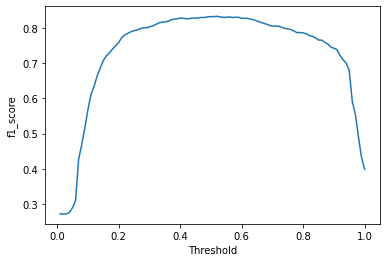

In [31]:
importlib.reload(B7)

y_proba = model.predict_proba(X_val)
y_proba = y_proba[:, 1] # keep only the second column

threshold = B7.Search().find_best_threshold(y_proba, y_val)

# results 
# normal USE + SVM, f1_score 0.82599
# large USE + SVM, f1_score 0.82796
# large USE + LR, f1_score 0.81551


In [34]:
# predict test and export csv
y_proba = model.predict_proba(vector_test)
final_preds = (y_proba >= threshold).astype(int)
sub = pd.read_csv(f"sample_submission.csv")
sub['target'] = final_preds
sub.to_csv('tweets.csv', index=False)
B7.Files().upload_vps('tweets.csv')

[05-15 05:50:15     INFO] tweets.csv was uploaded
